# 0. Introdução

**Created by:** Pedro V. Pinho N.

**Date:** 05/03/2020

**Contact:** peu.vpn@gmail.com

Nesse notebook está registrado a minha primeira tentativa com as competições de Machine Learning do Kaggle. O projeto registado aqui é referente a competição **"Titanic: Machine Learning from Disaster"**, https://www.kaggle.com/c/titanic, é uma competição de nível iniciante focada em Análise Exploratória de Dados e Engenharia de Parâmetros com o objetivo de desenvolver modelos preditivos para prever quais passageiros irão sobreviver ao acidente, baseado em parâmetros como ***idade**, **sexo**, **classe social**, **quantidade de filhos a bordo**, etc.

## 0.1. Pacotes Utilizados

In [1]:
import collections as cl

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

## 0.2. Leitura dos dados de treinamento

In [2]:
# Concatena dois DataFrames
def concat_df(df1, df2):
    return pd.concat([df1,df2], sort = True).reset_index(drop = True)

# Separa em dois DataFrames - Treinamento e Teste
def unconcat_df(df, len_train):
    return df.loc[:len_train - 1], df.loc[len_train:].drop(["Survived"], axis = 1)

#Leitura dos arquivos de teste e treinamento
df_train = pd.read_csv("./Data/train.csv")
df_test  = pd.read_csv("./Data/test.csv")

#Número entradas em cada parte dos dados
len_train = len(df_train)
len_test  = len(df_test)

# Data frame contendo todos os valores test + train
# Será utilizado para fazer as correções de 'missing values' e depois gerará os dois grupos (train e test)
df_all = concat_df(df_train, df_test)

#Nome dos DataFrames
df_train.name = 'Grupo de Treinamento'
df_test.name = 'Grupo de Teste'
df_all.name = 'Grupo Completo'

print('Formato do grupo de treinamento = {}'.format(df_train.shape))
print('Formato do grupo de teste = {}\n'.format(df_test.shape))

Formato do grupo de treinamento = (891, 12)
Formato do grupo de teste = (418, 11)



In [3]:
df_train.info()
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S
502,503,0,3,"O'Sullivan, Miss. Bridget Mary",female,NaN,0,0,330909,7.6292,NaN,Q
45,46,0,3,"Rogers, Mr. William John",male,NaN,0,0,S.C./A.4. 23567,8.0500,NaN,S


In [4]:
df_test.info()
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
378,1270,1,"Hipkins, Mr. William Edward",male,55.0,0,0,680,50.00,C39,S
127,1019,3,"McCoy, Miss. Alicia",female,NaN,2,0,367226,23.25,NaN,Q
277,1169,2,"Faunthorpe, Mr. Harry",male,40.0,1,0,2926,26.00,NaN,S


# 1. Preprocessamento e manipulação

* `PassengerId` identificação do passageiro, irrelevante para a análise
* `Survived` variável que desejamos prever (**0** or **1**):
    - **1 = Sobreviveu**
    - **0 = Não sobreviveu**
* `Pclass` (Passenger Class) é o status socio-econômico do passageiro e é categorizado em entradas númericas com **3** valores únicos (**1**,  **2 **or **3**):
    - **1 = Primeira Classe**
    - **2 = Segunda Classe**
    - **3 = Terceira Classe**
* `Name`, `Sex` and `Age` são auto-explicativos
* `SibSp` é o número total de irmãos e conjugês do passageiro
* `Parch` é o número total de parentes ou filhos do passageiro
* `Ticket` é o número do ticket do passageiro
* `Fare` é o valor pago pelo passageiro
* `Cabin` é a cabine do passageiro
* `Embarked` é o porto por qual o passageiro embarcou e é categorizado por 3 valores únicos (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

## 1.1. Categorização dos Títulos Honoríficos e Casamentos

O objetivo dessa subseção é categorizar os diferentes títulos presentes nos nomes dos passageiros, como por exemplo "Braund, **Mr.** Owen Harris" ou "Bowerman, **Miss.** Elsie Edith". Entretanto, como será possível ver, teremos muito títulos diferentes, o que dificulta qualquer tipo de análise e construção de modelo preditivo, assim, iremos mapear os títulos para 6 categorias mais abrangentes.

Podemos ver que todos os nomes são compostos e estruturados da seguinte forma: **sobrenome**(virgula)**título**(ponto)(espaço)**nome**. Basta portanto, primeiramente separar o nome em virgulas, o que nós entrega uma lista da seguinte forma: [**sobrenome**, **título**(ponto)(espaço)**nome**]. Pegando o segundo elemento e agora separando em ponto temos [**título**,(espaço)**nome**]. Basta então pegar agora o primeiro elemento e temos o nosso título.

Is_Married é um recurso binário baseado no título Mrs. O título de Mrs tem a maior taxa de sobrevivência entre outros títulos femininos. Este título precisa ser um recurso, porque todos os títulos femininos são agrupados.

In [5]:
# Cria uma nova coluna 'Title' com os títulos dos passageiros para uma consequente extração
df_all['Title'] = df_all.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
print(df_all['Title'].value_counts(),'\n')

# Mapeamento dos títulos
map_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

# Aplicando nos dados
df_all['Title'] = df_all['Title'].map(map_titles)
print(df_all['Title'].value_counts())

#É casado ou não
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Don               1
Jonkheer          1
Lady              1
Capt              1
the Countess      1
Sir               1
Mme               1
Dona              1
Name: Title, dtype: int64 

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64


## 1.2. Dados faltando

### 1.2.A. Idade

Claramente usaremos algum tipo de média das idades para preencher os valores faltantes, entretanto, pessoas de diferentes esferas possuem idades médias diferentes, por exemplo, homens possuem uma idade média maior que mulheres, e por ai vai. Portanto precisamos saber quais esferas - Classe, Sexo, Título - mais se correlaciona com os valores de idade.

Veremos que o parâmentro númerico que mais se relaciona com a idade é a classe social (Pclass) e vemos também que dentro das classes sociais a mulher sempre tem a menor idade média. Portanto vamos preencher os valores NaN com as médias respectivas de cada esfera.

In [6]:
# Correlação da idade com os parâmetros de valores númericos
corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
print(corr[corr['Feature 1'] == 'Age'],'\n')

# Agrupamento por 'Pclass' e 'Sex'
print(df_all.groupby(['Pclass', 'Sex']).median()['Age'])

# Preenchendo os valores faltantes com suas respectivas médias
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

   Feature 1    Feature 2  Correlation Coefficient
7        Age          Age                 1.000000
11       Age       Pclass                 0.408106
20       Age        SibSp                 0.243699
24       Age   Is_Married                 0.215091
31       Age         Fare                 0.178740
35       Age        Parch                 0.150917
41       Age     Survived                 0.077221
57       Age  PassengerId                 0.028814 

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64


### 1.2.B. Porto embarcado

In [7]:
# Encontrando valores faltantes
print(df_all[df_all['Embarked'].isnull()])

      Age Cabin Embarked  Fare                                       Name  \
61   38.0   B28      NaN  80.0                        Icard, Miss. Amelie   
829  62.0   B28      NaN  80.0  Stone, Mrs. George Nelson (Martha Evelyn)   

     Parch  PassengerId  Pclass     Sex  SibSp  Survived  Ticket Title  \
61       0           62       1  female      0       1.0  113572  Miss   
829      0          830       1  female      0       1.0  113572   Mrs   

     Is_Married  
61            0  
829           1  


Podemos ver que os únicos valoes que faltam na secção 'Embarked' são de duas mulheres de primeira classe que curiosamente estão na mesma cabine e possuem o mesmo ticket. Podemos então que elas se conhecem. Uma rápida busca no Google (https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html) nos fornece a informação que Martha Evelyn embarcou com sua empregada Amelie Icard no porto de **Southampton**.

In [8]:
# Preenchendo os valores faltantes
df_all["Embarked"] = df_all['Embarked'].fillna('S')

### 1.2.C. Preço da passagem

Podemos ver abaixo que o preço da passagem é bastante correlato com o tamanho da familia (**Parch** e **SibSp**) e a classe social (**Pclass**). Portanto faremos um procedimento similar ao da idade, agora agrupando por **Parch** **Pclass** e **SibSp**.

In [9]:
# Corelação entre Fare e outros parâmentros
print(corr[corr['Feature 1'] == 'Fare'])

# Calculando a tarifa média
df_all['Fare'] = df_all.groupby(['Pclass', 'SibSp', 'Parch']).Fare.apply(lambda x: x.fillna(x.median()))

   Feature 1    Feature 2  Correlation Coefficient
2       Fare         Fare                 1.000000
9       Fare       Pclass                 0.558629
18      Fare     Survived                 0.257307
23      Fare        Parch                 0.221539
30      Fare          Age                 0.178740
32      Fare        SibSp                 0.160238
37      Fare   Is_Married                 0.139245
54      Fare  PassengerId                 0.031428


### 1.2.D. Cabine

Com relação às cabines temos o mesmo problema dos títulos, muitas categorias. Teremos que fazer uma análise da composição de cada categoria para que possamos saber como agrupar-las. Analisando a enciclopedia titanica é possível descobrir que a letra presente na cabine representa o deck, com essa informação podemos criar uma nova coluna para armazena-la.

In [10]:
# Criação de uma coluna com os decks
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_deck = df_all.groupby(['Deck', 
                              'Pclass']).count().drop(columns = ['Age','Cabin',
                                                               'Embarked','Fare',
                                                               'Parch','PassengerId',
                                                               'Sex', 'SibSp',
                                                               'Survived',
                                                               'Ticket',
                                                               'Title']).rename({'Name': 'Counts'}).transpose()
print(df_all_deck)

Deck         A   B   C   D      E         F     G   M            T
Pclass       1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Name        22  65  94  40  6  34  4  3  13  8  5  67  254  693  1
Is_Married  22  65  94  40  6  34  4  3  13  8  5  67  254  693  1


* Decks **A**,**B** e **C**: **100% primeira classe**
* Deck **D**: **86,96% primeira classe** e **13,01% segunda classe**
* Deck **E**: **82,9% primeira classe**, **9,8% segunda classe** e **7,3% terceira classe**
* Deck **F**: **61,9% segunda classe**, **38,1% terceira classe**
* Deck **G**: **100% terceira classe**

Como o passageiro na classe **T** também é da primeira classe é recomendado coloca-lo na cabine **A**.

In [11]:
# mudando a cabine T para A

idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx,'Deck'] = 'A'

No momento o parâmetro cabine tem uma alta cardinalidade, então é de interesse analisar a taxa de sobrevivência dos Decks para que possamos agrupar decks com caracteristicas similares

In [12]:
df_all_survived = df_all.groupby(['Deck', 
                              'Survived']).count().drop(columns = ['Age','Cabin',
                                                               'Embarked','Fare',
                                                               'Parch','PassengerId',
                                                               'Sex', 'SibSp',
                                                               'Pclass',
                                                               'Ticket',
                                                               'Title']).rename({'Name': 'Counts'}).transpose()

print(df_all_survived)

Deck         A       B       C       D       E       F       G        M     
Survived   0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  0.0  1.0
Name         9   7  12  35  24  35   8  25   8  24   5   8   2   2  481  206
Is_Married   9   7  12  35  24  35   8  25   8  24   5   8   2   2  481  206


* Deck A: **43,7%** sobreviveram
* Deck B: **74,5%** sobreviveram
* Deck C: **59,3%** sobreviveram
* Deck D: **75,8%** sobreviveram
* Deck E: **75%** sobreviveram
* Deck F: **61,5%** sobreviveram
* Deck G: **50%** sobreviveram
* Deck M: **29,9%** sobrevivera

Decks com classes mais altas possuem maior chance de sobrevivência. Podemos agrupar os decks **A**, **B** e **C** em um só **ABC**. Façamos isso com as outras cabines que apresentam caracteristicas igual como classe pertencente e taxa de sobrevivência:

* A, B e C -> **ABC**
* D e E -> **DE**
* F e G -> **FG**

In [13]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F','G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

## 1.3. Intervalos para os parâmetros

### 1.3.1 Fare

Os grupos no lado esquerdo do gráfico têm a menor taxa de sobrevivência e os grupos no lado direito do gráfico têm a maior taxa de sobrevivência.

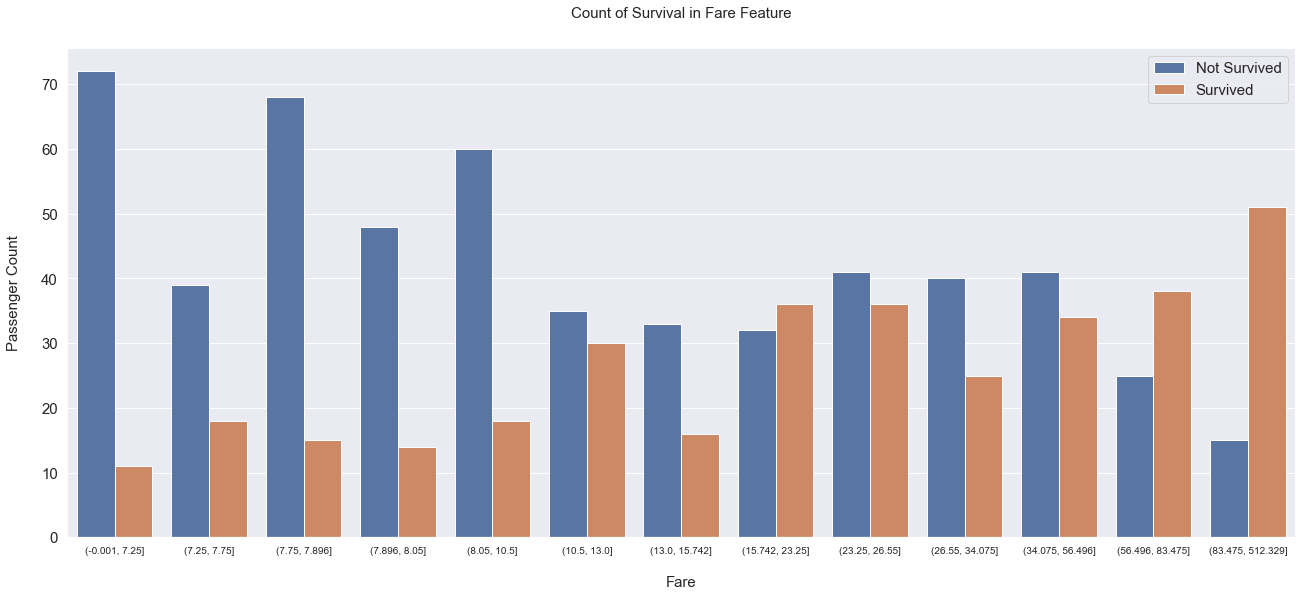

In [14]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

### 1.3.2. Age

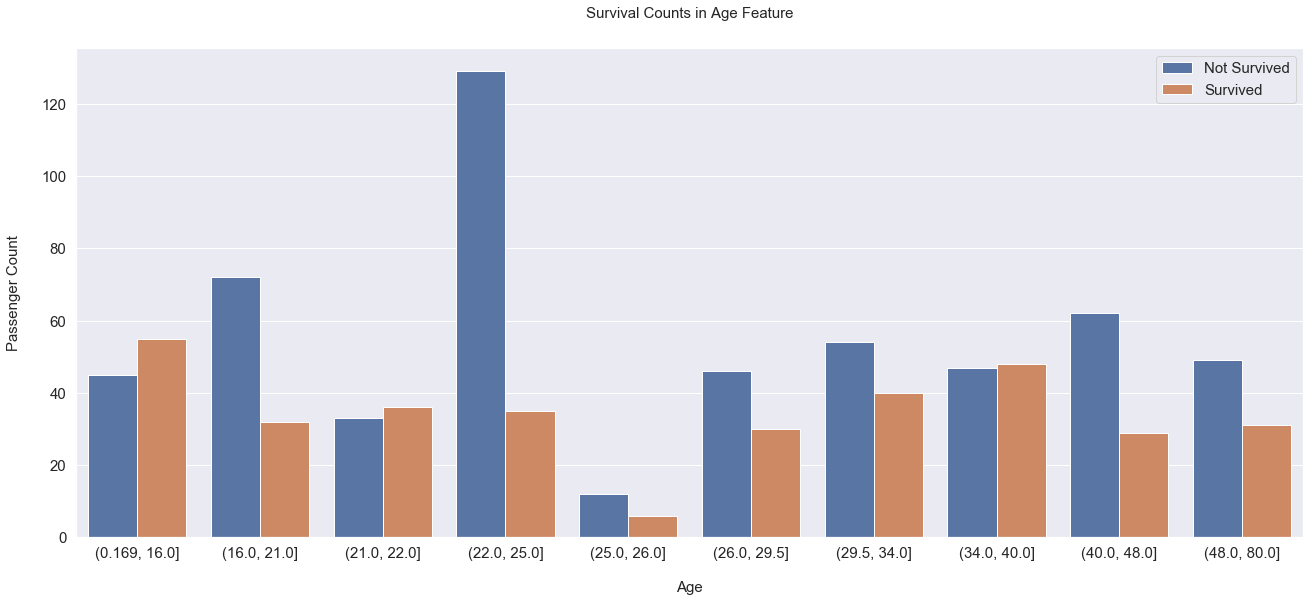

In [15]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

## 1.4. Tamanho da Familia

Para entender melhor os parâmetros SibSp e Parch é de interesse criar um parâmetro auxiliar chamado Family_Size, que de acordo com os gráficos tem relevância na taxa de sobrevivência. O tamanho das famílias são dadas por **Family_Size = SibSp + Parch + 1**

Os tamanhos são categorizados como:
* **1**: Sozinho
* **2**, **3**, **4**: Pequeno
* **5** e **6**: Médio 
* **7**, **8** e **11**: Grande

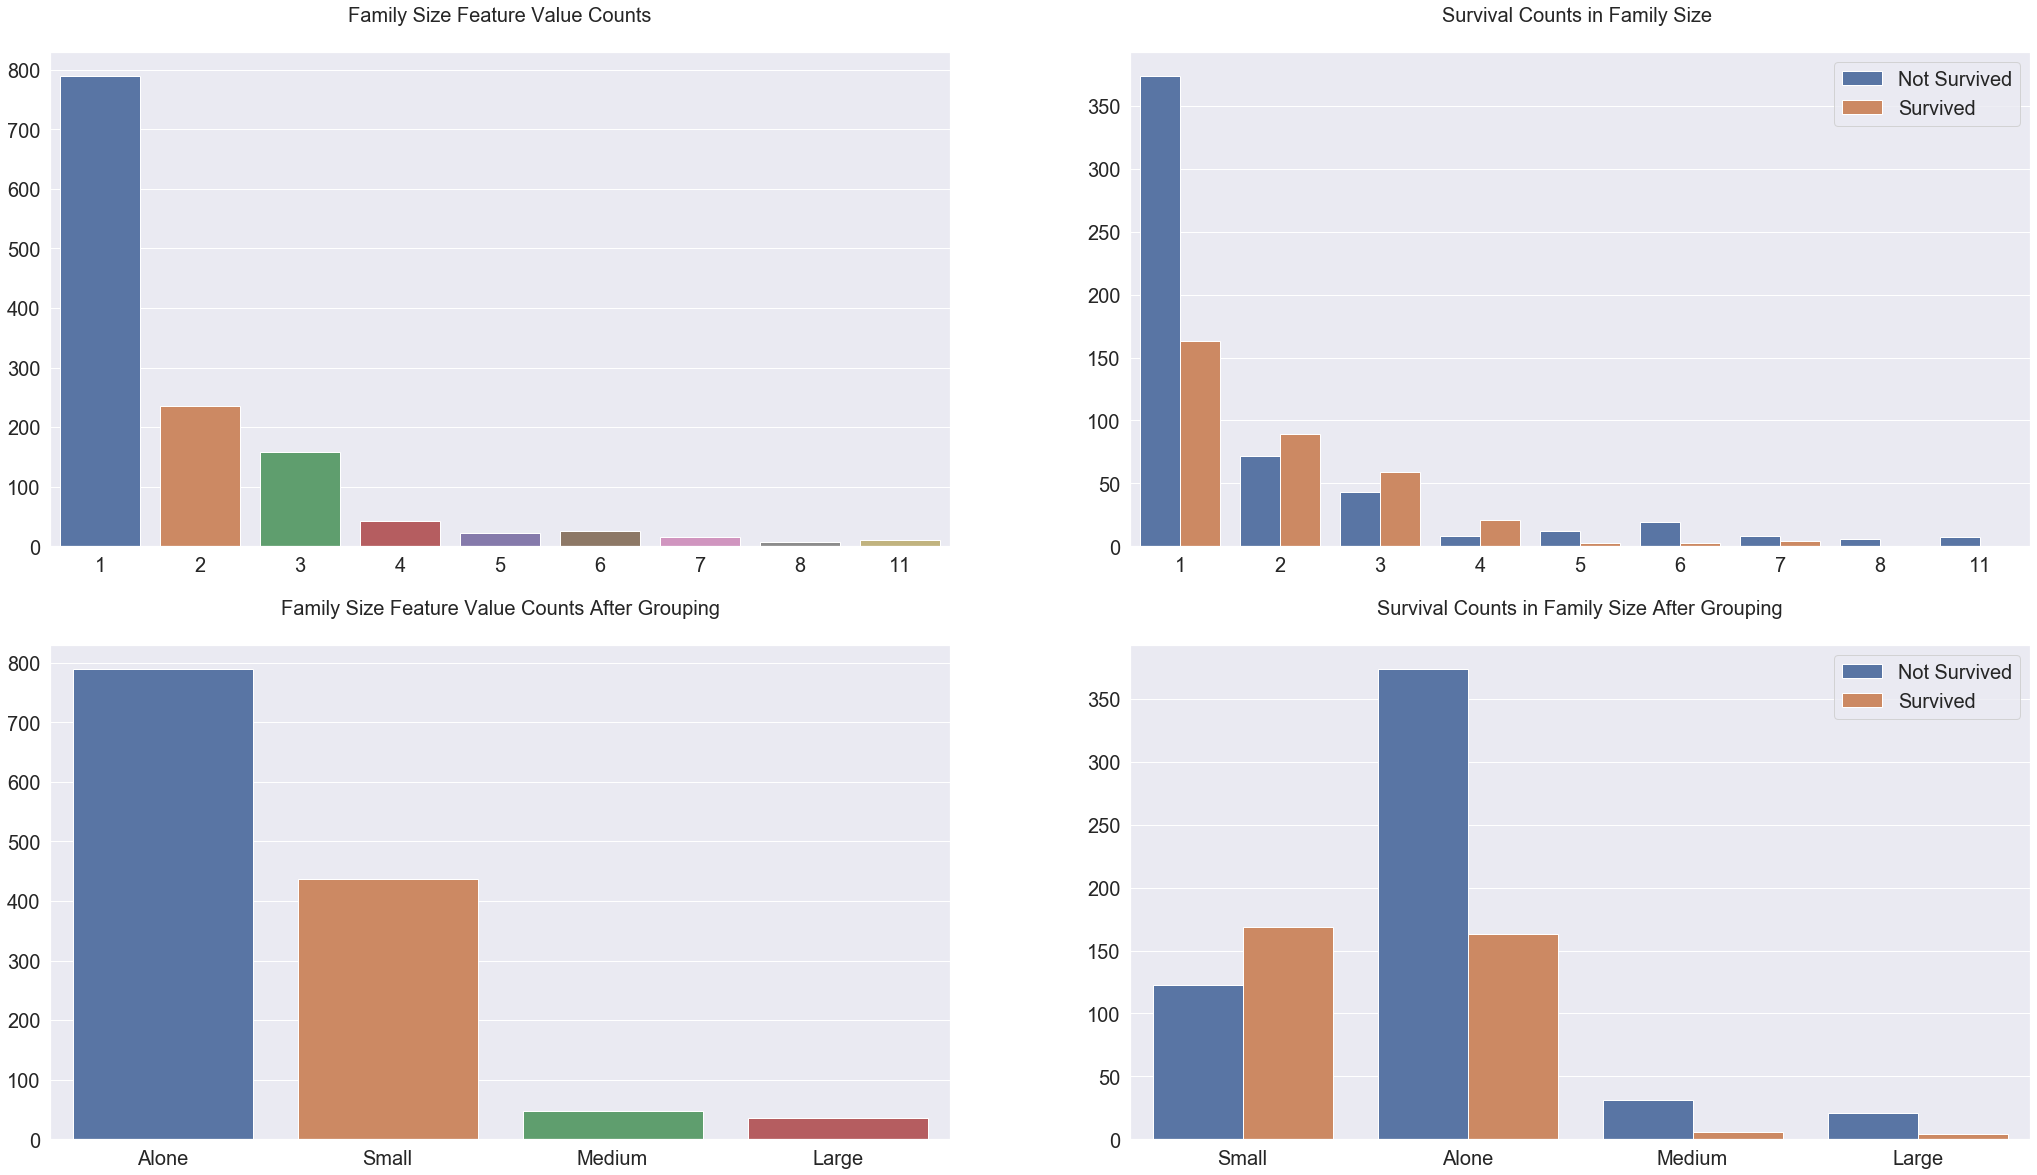

In [16]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

## 1.5. Frequência dos Tickets

Existem muitos valores exclusivos de ticket para analisar, portanto, agrupá-los por suas frequências facilita as coisas. Muitos passageiros viajaram junto com grupos. Esses grupos consistem em amigos, babás, criadas e etc. Eles não eram contados como família, mas usavam o mesmo ingresso.

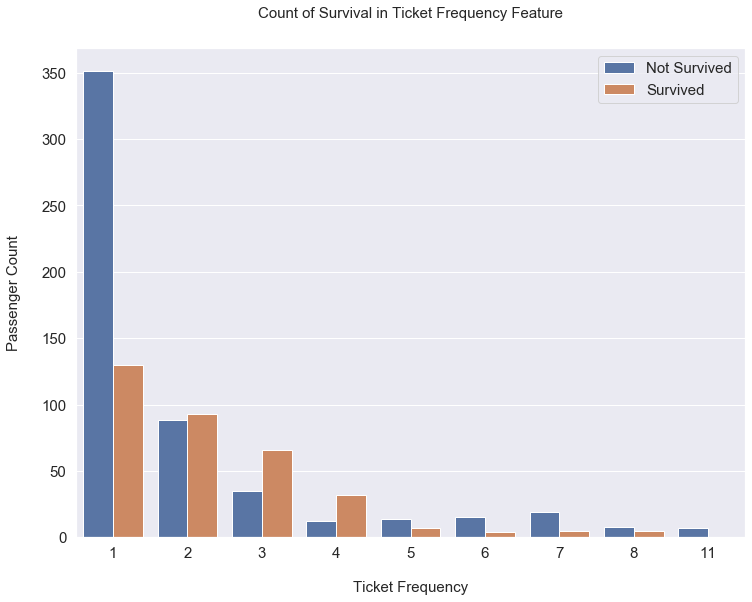

In [17]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

## 1.6. Codificação dos valores

In [18]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

#Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')['Survived', 'Family','Family_Size'].median()
df_ticket_survival_rate = df_train.groupby('Ticket')['Survived', 'Ticket','Ticket_Frequency'].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [19]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2

In [20]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']
dfs = [df_train, df_test]

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])
        
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

df_all = concat_df(df_train, df_test)
drop_cols = ['Cabin','Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)
df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.383838,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,1.0,2,0.0,0.0,0.0,1.0,0.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.383838,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.383838,0.0,2,0.0,0.0,0.0,1.0,0.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.383838,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0


# 2. Modelo

In [21]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 28)
y_train shape: (891,)
X_test shape: (418, 28)


## 2.1. Random Forest

In [22]:
model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = model.feature_importances_
        
    oob += model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 1 OOB Score: 0.8581460674157303

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 2 OOB Score: 0.8497191011235955

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 3 OOB Score: 0.8288920056100981

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 4 OOB Score: 0.8359046283309958

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 5 OOB Score: 0.8417366946778712

Average OOB Score: 0.8428796994316583


,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0
